In [2]:
#Imports
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import os
import os.path
import random


#Set the image size and path to the data
img_size = (300,400)
img_path = 'Images/'
img_paths = []
img_annotations = []

#The images are stored in subdirectories - go through all of them
for dirpath, dirnames, filenames in os.walk(img_path):
    for filename in [f for f in filenames if f.endswith(".jpg")]:
        img_paths.append(os.path.join(dirpath, filename))
        img_annotations.append(dirpath.split('/')[1].split('-')[1])

print(img_paths[-5:-1])
print(img_annotations[-5:-1])

['Images/n02116738-African_hunting_dog\\n02116738_9798.jpg', 'Images/n02116738-African_hunting_dog\\n02116738_9818.jpg', 'Images/n02116738-African_hunting_dog\\n02116738_9829.jpg', 'Images/n02116738-African_hunting_dog\\n02116738_9844.jpg']
['African_hunting_dog', 'African_hunting_dog', 'African_hunting_dog', 'African_hunting_dog']


In [3]:
img_data = []
for path in img_paths[0:1000]:
    img_data.append(color.rgb2grey(resize(plt.imread(path).astype(np.uint8),img_size)).flatten())
img_annotations = img_annotations[0:1000]

## DAISY Feature Extraction
We decided to do a DAISY feature extraction to test how well it would perform in the classification task we had at hand. The following cells show how it was applied on the first image in our dataset that we worked with, with the important note that we selected a bigger step to better visualize the descriptor.

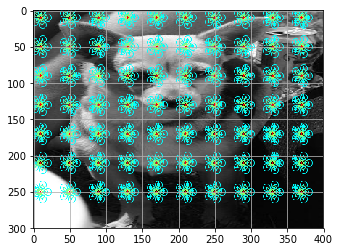

In [5]:
from skimage.feature import daisy
%matplotlib inline
img = img_data[0].reshape(img_size)
# visualize daisy descriptor
features, img_desc = daisy(img,step=40, radius=10, rings=3, histograms=5, orientations=8, visualize=True)
plt.imshow(img_desc)
plt.grid()

Below is the original image:

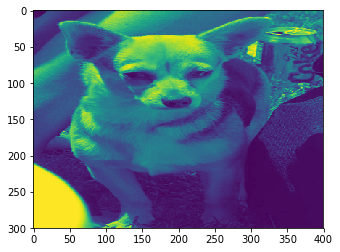

In [6]:
plt.imshow(img)

We estimated how many features would be extracted with the settings that were applied and ran the DAISY descriptor on all images in our dataset.

In [7]:
# now let's understand how to use it
features = daisy(img,step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

(28, 38, 104)
110656


In [8]:
# create a function to take in the row of the matrix and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(img_data[0],img_size)
test_feature.shape

Wall time: 250 ms


(110656,)

In [9]:
# apply to entire data, row by row
#takes about 4 minutes to run on dataset of size 1000
%time daisy_features = np.apply_along_axis(apply_daisy, 1, img_data, img_size)
print(daisy_features.shape)

Wall time: 3min 40s
(1000, 110656)


We calculated the pairwise distances for each feature and image.

In [11]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

Wall time: 2.73 s


The DAISY desciptor performed pretty well on the first image of our dataset, and was easily able to identify another dog of the same breed - Chihauhua. 

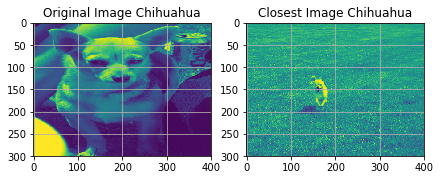

In [12]:
import copy
# find closest image to current image
idx1 = 0
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
plt.imshow(img_data[idx1].reshape(img_size))
plt.title("Original Image " + img_annotations[idx1])
plt.grid()

plt.subplot(1,2,2)
plt.imshow(img_data[idx2].reshape(img_size))
plt.title("Closest Image " + img_annotations[idx2])
plt.grid()

The following widget allows for easy scrolling through all images in the dataset and their two closest neighbors based on the DAISY descriptors.

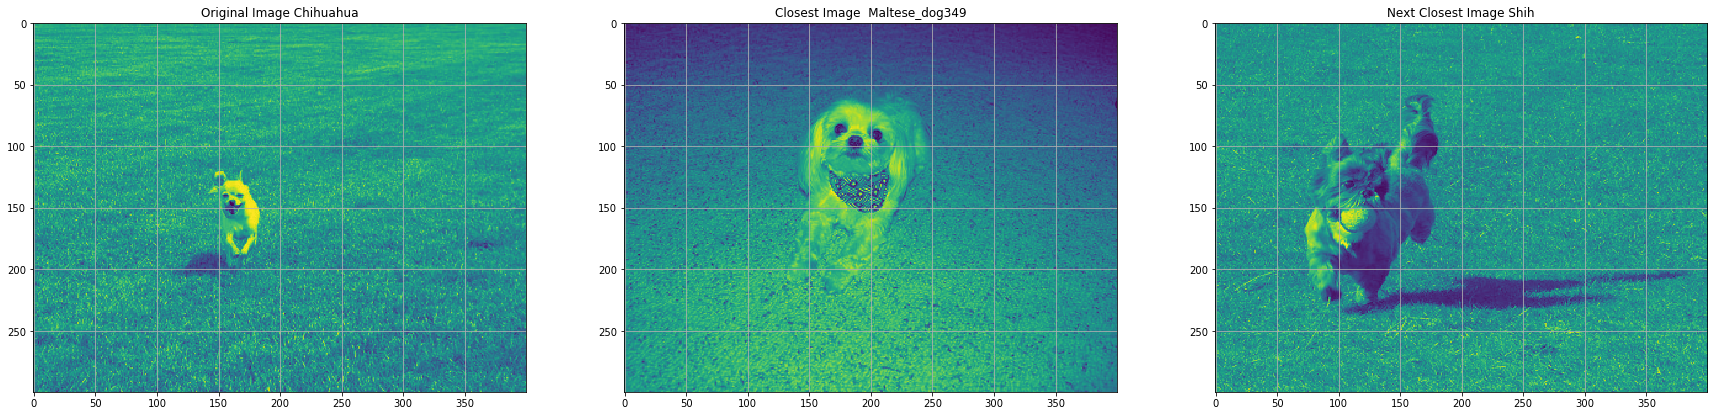

In [16]:
from ipywidgets import fixed
from ipywidgets import widgets  # make this interactive!
import warnings
warnings.simplefilter('ignore', FutureWarning)
# compare the different methods
# put it together inside a nice widget
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(30,40))
    plt.subplot(1,3,1)
    plt.imshow(img_data[idx1].reshape(img_size))
    plt.title("Original Image "+img_annotations[idx1])
   
    plt.grid()

    plt.subplot(1,3,2)
    plt.imshow(img_data[idx2].reshape(img_size))
    plt.title("Closest Image  "+img_annotations[idx2] + str(idx2))
    plt.grid()
    
    plt.subplot(1,3,3)
    plt.imshow(img_data[idx3].reshape(img_size))
    plt.title("Next Closest Image "+img_annotations[idx3])
    plt.grid()
    
widgets.interact(closest_image,idx1=(0,999,1),dmat=fixed(dist_matrix),__manual=True)

We can see easily that the DAISY descriptors did not perform too badly with this dataset, even though some of its predictions were incorrect. We can also see that the surroundings affected the pairwise differences between images, as they were not always close ups of the specific breed, and the background, such as the grass in image 44 (Chihuahua), was a reason for the algorithm to make mistakes in its predictions.

In [17]:
#label_indexes contains all the indexes where the breed changes.
#labels contains all breeds currently present in the subset.
label_indexes = [i for i in range(1,len(img_annotations)) if img_annotations[i]!=img_annotations[i-1] ]
labels = [img_annotations[x] for x in label_indexes]
label_indexes


[152, 337, 589, 738, 952]

In [18]:
#splits daisy features by breed, the takes the average of each feature
daisy_features_split = np.array_split(daisy_features, label_indexes)
avg_features = [sum(x)/len(x) for x in list(daisy_features_split)]
avg_features = np.array(avg_features)
print(avg_features[0:5,0:5])

[[ 0.00684207  0.00720791  0.00809007  0.00735071  0.00843169]
 [ 0.00774912  0.00831392  0.00778042  0.00684225  0.0080211 ]
 [ 0.00779265  0.00816885  0.00867567  0.00814898  0.00980151]
 [ 0.00776284  0.00813668  0.00831458  0.00790873  0.00919583]
 [ 0.00861905  0.00847034  0.00800195  0.00748591  0.0094383 ]]


In [20]:
import pandas
#unsuccessful try to 
import seaborn as sns
%matplotlib inline
df = pandas.DataFrame(avg_features)
sns.heatmap(df.corr())

MemoryError: 

TypeError: '<' not supported between instances of 'str' and 'float'

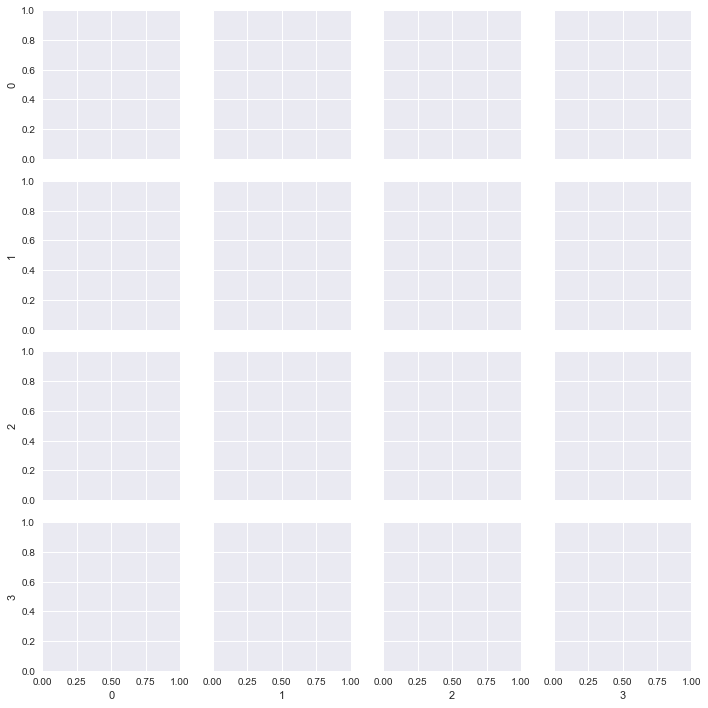

In [24]:
#unsuccessful attempt for a pairplot of top 5 features, think it's treating the floats as objects for some reason
import seaborn as sns
%matplotlib inline

df = avg_features[0:5,0:4]
col = np.array(labels)
df = np.column_stack((df,col))
df = pd.DataFrame(df)
df= df.rename(columns={4:'Breed'})
df.head()
# # sns.heatmap(, annot=True)
sns.set()
sns.pairplot(df,hue="Breed")